# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

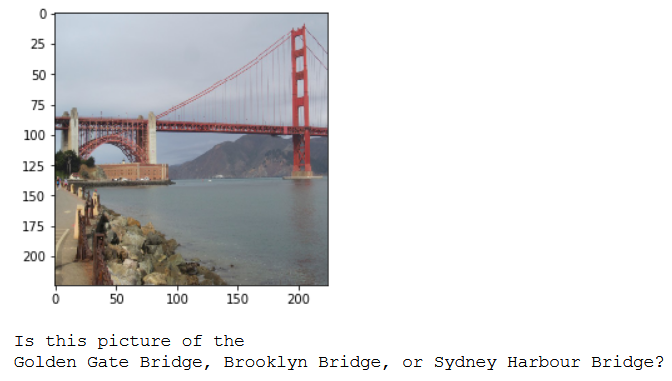

In [1]:
from IPython.display import Image
Image(filename=r"images/sample_landmark_output.png")

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data.sampler import SubsetRandomSampler
import helper

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

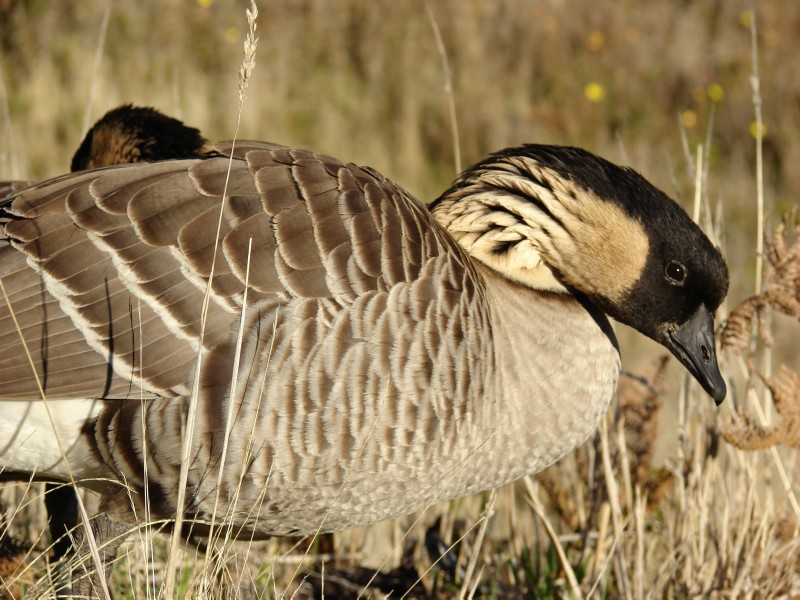

In [3]:
from IPython.display import Image
Image(filename=r"images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg")

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [4]:
# We create data loaders to manage and transform images during the model building and validation phases

# No. of subprocesses used for data loading
num_workers = 8
# No. of samples per batch to load
#batch_size = 20
batch_size = 20
# Split between training and validation
valid_size = 0.2

# Basic conversion to  normalised torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(266),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load data from file
train_data = datasets.ImageFolder('c:\\users\\pc-1\\documents\\github\\deep-learning\\notebooks\\landmark_project'
                                  '\\landmark_images\\train', transform=transform)
test_data = datasets.ImageFolder('c:\\users\\pc-1\\documents\\github\\deep-learning\\notebooks\\landmark_project'
                                  '\\landmark_images\\test', transform=transform)

# Create training and validation indices lists split randomly according to validation size
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create random sampling objects to create training and validation batches from indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Finally create data loaders using all of above i.e. data and indices/ samplers
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
n_classes = len(train_data.classes)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
- I resized images to 266x266 and then cropped them down to 256x256. I chose this size as I believe it to be large
enough to obtain realistic results on images with much larger dimensions without affecting performance too adversely.
Many successful architectures such as ResNet use image sizes of similar magnitude e.g. 244 (this is a weird number
choice though as the number does not seem to have any particular functional value, I will research this particular
choice further as I am sure there is a good reason for the choice. For now, I however preferred the choice of a size
being a power of 2, for obvious reasons). The input tensor will hence be 256x256x3 for RGB.
- No, I did not augment my dataset. This is the first CNN I am building from scratch and hence want to keep it as
simple as possible to baseline the model. Once I understand how the datasets are built using the original dataset, I
will start looking at augmentation and then compare to my existing baseline.


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

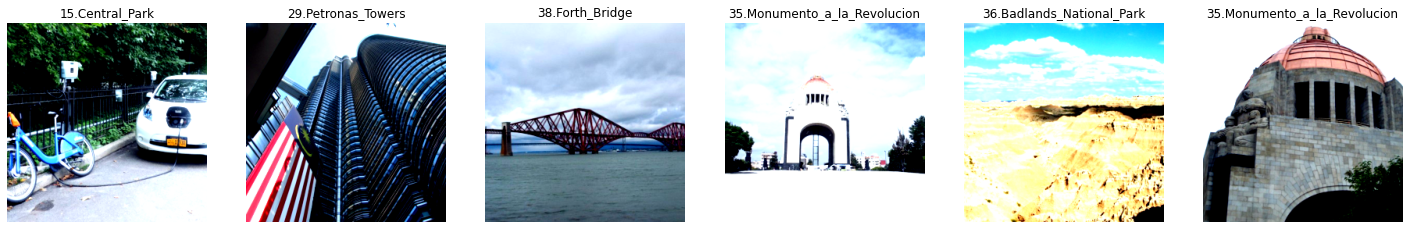

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Instantiate a training set dataloader
train_iter = iter(loaders_scratch['train'])

# Obtain a batch of images and labels
images, labels = next(train_iter)

# Plot set No. of images and labels
fig, axes = plt.subplots(figsize=(25,10), ncols=6)
for i in range(6):
    ax = axes[i]
    helper.imshow(images[i], ax=ax, normalize=True)
    ax.set_title(train_data.classes[labels[i]])

### Initialize use_cuda variable

In [6]:
# Checking if CUDA is set up properly on my system
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
# Loss function
criterion_scratch = nn.CrossEntropyLoss()

# Optimiser
def get_optimizer_scratch(model):
    return optim.Adam(model.parameters(), lr=0.0008)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        # convolutional layer (sees 128x128x16 tensor)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        # convolutional layer (sees 32x32x64 tensor)
        #self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        #self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.4)

        # linear layer (128 * 16 * 16 -> 1024)
        self.fc1 = nn.Linear(256 * 32 * 32, 1024)
        # linear layer (1024 -> 512)
        #self.fc2 = nn.Linear(2048, 2048)
        # linear layer (512 -> 256)
        self.fc3 = nn.Linear(1024, n_classes)
        #self.fc3 = nn.Linear(512, n_classes)
        # linear layer (256 -> )
        #self.fc4 = nn.Linear(256, 256)
        #self.fc5 = nn.Linear(256, n_classes)

        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.relu = nn.ReLU()

        # Batch norm
        self.batch_norm2d = nn.BatchNorm2d(128)
        self.batch_norm1d = nn.BatchNorm1d(1024)

    def forward(self, x):
        ## Define forward behavior
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x)
        #x = self.pool(self.leaky_relu(self.conv1_2(x)))
        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x)
        #x = self.pool(self.leaky_relu(self.conv2_2(x)))
        x = self.batch_norm2d(x)
        x = self.leaky_relu(self.conv3(x))
        #x = self.pool(self.leaky_relu(self.conv3_2(x)))
        x = self.pool(x)
        #x = self.leaky_relu(self.conv4(x))
        #x = self.pool(x)
        #x = self.pool(self.leaky_relu(self.conv4_2(x)))

        # flatten image input
        x = x.view(-1, 256 * 32 * 32)

        # add 1st hidden layer, with leaky_relu activation function
        x = self.leaky_relu(self.fc1(x))
        x = self.batch_norm1d(x)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with leaky_relu activation function
        #x = self.leaky_relu(self.fc2(x))
        #x = self.fc2(x)
        # add dropout layer
        #x = self.dropout(x)
        # add 3rd hidden layer, with leaky_relu activation function
        #x = self.leaky_relu(self.fc3(x))
        x = self.fc3(x)
        #x = self.fc3(x)
        # add dropout layer
        #x = self.dropout(x)
        # add 4th hidden layer, with linear activation function
        #x = self.leaky_relu(self.fc4(x))
        #x = self.fc5(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    torch.cuda.empty_cache()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=262144, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=50, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (batch_norm2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm1d): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__
- I started with the code supplied in the CIFAR-10 tutorial. This was a good start but did not result in great
results. The first thing I changed was the image sizes used. The CIFAR images were way too small and hence a lot of
potential signal in the data was lost. I studied the lecture material and references to the CS231 lecture notes
regarding CNN architectures and starting considering the VGG16 architecture. I chose image sizes of 256 as previously
discussed.
- Next thing I changed was the optimiser. I have used Adam before, and liked it, so I changed the optimiser to Adam.
- I then played with the learning rate for a long time. I started with very small numbers i.e. 0.000001 and very
large numbers i.e. 1.0 and worked upwards and downwards simultaneously to converge on best order of magnitude to use.
I settled on 0.001 (0.005 was too large). This parameter affects the results substantively, so a more scientific
approach will help a lot here.
- I then played with the activation function and tested both Relu and LeakyRelu. It seems as if either worked fine as
long as other parameters are optimally chosen.
- At this point I managed validation losses around 2.5, which is the lowest I obtained in the whole exercise. At this
 point the validation error would however increase as training error decreased to well below 0.05.
- I therefore added drop-out layers to try and stabilise the validation error. This didn't seem to help much, so I
started updating the architecture to look more like VGG16. This also did not seem to help at this point, so I
reverted changes made and stuck with my original design. For some reason I never managed to get the same results I
did before, but still managed to pass the accuracy test of 20%!
- The model is fairly stable and the validation error decreases relative to the training error during the entire
training process which is good. I only trained for 20 epochs, so training for 100 epochs should increase accuracy but
needs to be tested. However, I would probably need to find ways of reducing over-fitting as during training I did
have considerable problems on front.
- I used the mean and std values for Pytorch normalisation as found in the following post:
https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                torch.cuda.empty_cache()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                torch.cuda.empty_cache()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2.0/ n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.091827 	Validation Loss: 3.410521
Validation loss decreased (inf --> 3.410521).  Saving model ...
Epoch: 2 	Training Loss: 3.221481 	Validation Loss: 3.200506
Validation loss decreased (3.410521 --> 3.200506).  Saving model ...
Epoch: 3 	Training Loss: 2.407127 	Validation Loss: 3.406464
Epoch: 4 	Training Loss: 1.233279 	Validation Loss: 3.651025
Epoch: 5 	Training Loss: 0.414456 	Validation Loss: 4.189981
Epoch: 6 	Training Loss: 0.132139 	Validation Loss: 4.188015
Epoch: 7 	Training Loss: 0.044965 	Validation Loss: 4.189370
Epoch: 8 	Training Loss: 0.022324 	Validation Loss: 4.348918
Epoch: 9 	Training Loss: 0.014637 	Validation Loss: 4.272156
Epoch: 10 	Training Loss: 0.010605 	Validation Loss: 4.497539


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.742090 	Validation Loss: 3.373209
Validation loss decreased (inf --> 3.373209).  Saving model ...
Epoch: 2 	Training Loss: 3.159399 	Validation Loss: 3.177423
Validation loss decreased (3.373209 --> 3.177423).  Saving model ...
Epoch: 3 	Training Loss: 2.607143 	Validation Loss: 3.029854
Validation loss decreased (3.177423 --> 3.029854).  Saving model ...
Epoch: 4 	Training Loss: 1.831507 	Validation Loss: 3.154504
Epoch: 5 	Training Loss: 0.905400 	Validation Loss: 3.554921
Epoch: 6 	Training Loss: 0.366555 	Validation Loss: 4.085576
Epoch: 7 	Training Loss: 0.135375 	Validation Loss: 3.885966
Epoch: 8 	Training Loss: 0.053391 	Validation Loss: 4.052359
Epoch: 9 	Training Loss: 0.019678 	Validation Loss: 4.096511
Epoch: 10 	Training Loss: 0.012227 	Validation Loss: 4.066349
Epoch: 11 	Training Loss: 0.009128 	Validation Loss: 4.128592
Epoch: 12 	Training Loss: 0.004189 	Validation Loss: 4.129040
Epoch: 13 	Training Loss: 0.003219 	Validation Loss: 4.123217
E

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.948282


Test Accuracy: 29% (372/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
# We create data loaders to manage and transform images during the model building and validation phases

# No. of subprocesses used for data loading
num_workers = 8
# No. of samples per batch to load
#batch_size = 20
batch_size = 64
# Split between training and validation
valid_size = 0.2

# Basic conversion to  normalised torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load data from file
train_data = datasets.ImageFolder('c:\\users\\pc-1\\documents\\github\\deep-learning\\notebooks\\landmark_project'
                                  '\\landmark_images\\train', transform=transform)
test_data = datasets.ImageFolder('c:\\users\\pc-1\\documents\\github\\deep-learning\\notebooks\\landmark_project'
                                  '\\landmark_images\\test', transform=transform)

# Create training and validation indices lists split randomly according to validation size
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create random sampling objects to create training and validation batches from indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Finally create data loaders using all of above i.e. data and indices/ samplers
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
transfer_classes = len(train_data.classes)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [14]:
## TODO: select loss function
# Loss function
criterion_transfer = nn.CrossEntropyLoss()

# Optimiser
def get_optimizer_transfer(model):
    return optim.SGD(model.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
# Specify model architecture
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, transfer_classes)

model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

In [16]:
# print out the model structure
print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

- I continued using the VGG16 model as per the previous model. I now however used the image sizes of the original
network and hence had to rewrite my dataloaders to load the data in the correct format.
- Unlike before, I opted to use the SGD optimiser as per the original VGG16 model. I used the CS231 lecture notes as
guide to adapt the model.
- I used the Udacity lecture notes to freeze the feature layers and to add the final output layer.
- Voila - all done! This was super simple compared to the previous model, for which I had to do a tremendous amount
of time-consuming experimentation.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# Train the model and save the best model parameters at filepath 'model_transfer.pt'
train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, 'model_transfer.pt')



#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.980352 	Validation Loss: 2.095142
Validation loss decreased (inf --> 2.095142).  Saving model ...
Epoch: 2 	Training Loss: 1.882536 	Validation Loss: 1.542988
Validation loss decreased (2.095142 --> 1.542988).  Saving model ...
Epoch: 3 	Training Loss: 1.540244 	Validation Loss: 1.357235
Validation loss decreased (1.542988 --> 1.357235).  Saving model ...
Epoch: 4 	Training Loss: 1.376846 	Validation Loss: 1.319609
Validation loss decreased (1.357235 --> 1.319609).  Saving model ...
Epoch: 5 	Training Loss: 1.280251 	Validation Loss: 1.293397
Validation loss decreased (1.319609 --> 1.293397).  Saving model ...
Epoch: 6 	Training Loss: 1.219864 	Validation Loss: 1.239358
Validation loss decreased (1.293397 --> 1.239358).  Saving model ...
Epoch: 7 	Training Loss: 1.130857 	Validation Loss: 1.203003
Validation loss decreased (1.239358 --> 1.203003).  Saving model ...
Epoch: 8 	Training Loss: 1.112139 	Validation Loss: 1.147539
Validation loss decreased (1.20300

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.967131


Test Accuracy: 72% (912/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [19]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    img=Image.open(img_path).convert('RGB')

    transform=transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    #from image to tensor
    image_tensor = transform(img).float()
    #adds a dimension with a length of one
    image_ten = image_tensor.unsqueeze_(0)

    if use_cuda:
        img=image_ten.cuda()

    model_transfer.eval()  #evaluation mode
    output = model_transfer(img)
    top_values, top_idx = torch.topk(output, k, dim=1, largest=True, sorted=True)

    top_classes = [train_data.classes[class_id] for class_id in top_idx[0].tolist()]

    return top_classes

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '30.Brooklyn_Bridge',
 '28.Sydney_Harbour_Bridge',
 '06.Niagara_Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

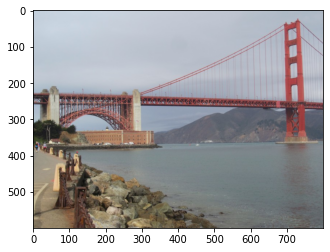

Is this a picture of the:
09.Golden_Gate_Bridge, 30.Brooklyn_Bridge, or 38.Forth_Bridge?


In [20]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this a picture of the:')
    print('%s, %s, or %s?' % (predicted_landmarks[0], predicted_landmarks[1],predicted_landmarks[2]))

# test on a sample image
suggest_locations(r"images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg")

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

- I cannot believe how easy it was to use a pretrained model. And results were astounding. More than double the
previous model accuracy, with very little time spent in experimentation with the model.
- Some areas for improvement:
    - The model will generalise better if more pictures are used to train the model.
    - Irrespective of more images being available, a more comprehensive validation of model accuracy of images
    outside of the training set is required to quantify generalisability.
    - I will look into using image augmentation to improve model accuracy.
    - I am sure the model can be further improved by using more complex models than VGG16. I will investigate these.

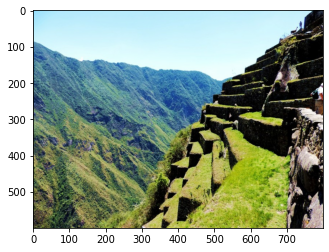

Is this a picture of the:
41.Machu_Picchu, 46.Great_Wall_of_China, or 00.Haleakala_National_Park?


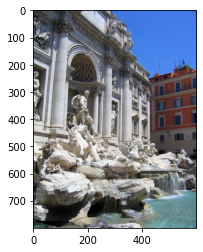

Is this a picture of the:
44.Trevi_Fountain, 49.Temple_of_Olympian_Zeus, or 11.Mount_Rushmore_National_Memorial?


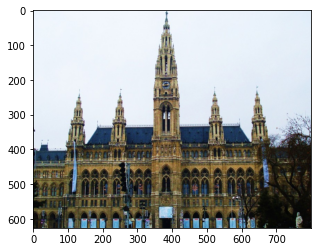

Is this a picture of the:
19.Vienna_City_Hall, 14.Terminal_Tower, or 48.Whitby_Abbey?


In [21]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import os

for filename in os.listdir('download'):
    suggest_locations(os.path.join("download", filename))
